In [8]:
from dolfinx import default_scalar_type
from dolfinx.fem import (Constant,  Function, functionspace, assemble_scalar, 
                         dirichletbc, form, locate_dofs_topological)
from dolfinx.fem.petsc import LinearProblem
from dolfinx.io import XDMFFile
from dolfinx.mesh import create_unit_square, locate_entities, meshtags
from dolfinx.plot import vtk_mesh

from mpi4py import MPI
from ufl import (FacetNormal, Measure, SpatialCoordinate, TestFunction, TrialFunction, 
                 div, dot, dx, grad, inner, lhs, rhs)

import numpy as np
import pyvista

mesh = create_unit_square(MPI.COMM_WORLD, 10, 10)

In [ ]:
u_ex = lambda x: 1 + x[0]**2 + 2*x[1]**2

x = SpatialCoordinate(mesh)
# Define physical parameters and boundary condtions
s = u_ex(x)
f = -div(grad(u_ex(x)))

from ufl import FacetNormal
n = FacetNormal(mesh)
g = -dot(n, grad(u_ex(x)))


kappa = Constant(mesh, default_scalar_type(1))
r = Constant(mesh, default_scalar_type(1000))
# Define function space and standard part of variational form
V = functionspace(mesh, ("Lagrange", 1))
u, v = TrialFunction(V), TestFunction(V)


#definisco una F iniziale che non contiene i termini di suoerficie (dovuti alle Neumann o Robin BC)
F = kappa * inner(grad(u), grad(v)) * dx - inner(f, v) * dx

In [ ]:
boundaries = [(1, lambda x: np.isclose(x[0], 0)),
              (2, lambda x: np.isclose(x[0], 1)),
              (3, lambda x: np.isclose(x[1], 0)),
              (4, lambda x: np.isclose(x[1], 1))]
#boundaries è quindi una lista di tuple 
# lambda x: np.isclose(....) saranno i "locator" 
# 1,2,3,4 saranno i "marker" 

In [ ]:
facet_indices, facet_markers = [], []
fdim = mesh.topology.dim - 1
for (marker, locator) in boundaries:
    facets = locate_entities(mesh, fdim, locator) # individuo gli indici delle entities (facets) appartenenti ad un particolare boundary 
    facet_indices.append(facets) # aggiungo gli indici appena trovati a "facet_indices"
    facet_markers.append(np.full_like(facets, marker)) # appendo a facet_marker un array delle stesse dimensioni di quello che conteneva gli indici appena trovati (ovvero facets) 
    # ma con tutti gli elementi al suo interno uguali al "marker" di riferimento!!! (Quindi, ad esempio, un array di tutti 1)

facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)


sorted_facets = np.argsort(facet_indices) # It returns an array of indices of the same shape as 'facet_indices' that contiene gli indici degli elementi di 'facet_indices' ordinati in maniera crescente 
# Ad esempio, se: facet_indices = np.array([3, 1, 2]) allora: np.argsort(facet_indices) = array([1, 2, 0])


facet_tag = meshtags(mesh, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets]) # Create a MeshTags object that associates data with a subset of mesh entities.
#facet_indices[sorted_facets] e facet_markers[sorted_facets] saranno 2 array contenenti rispettivamente gli indici degli entities appartenenti ai boundaries (ordinati in maniera crescente)
#ed i rispettivi markers identificativi(1,2,3,4)

# Debugging boundary condition
To debug boundary conditions, the easiest thing to do is to visualize the boundary in Paraview by writing the MeshTags to file. We can then inspect individual boundaries using the Threshold-filter.

In [12]:
mesh.topology.create_connectivity(mesh.topology.dim-1, mesh.topology.dim)
with XDMFFile(mesh.comm, "facet_tags.xdmf", "w") as xdmf:
    xdmf.write_mesh(mesh)
    xdmf.write_meshtags(facet_tag, mesh.geometry)

Now we can create a custom integration measure ds, which can be used to restrict integration. 

If we integrate over ds(1), we only integrate over facets marked with value 1 in the corresponding facet_tag.

In [19]:
ds = Measure("ds", domain=mesh, subdomain_data=facet_tag)

We can now create a general boundary condition class.

In [20]:
class BoundaryCondition():
    def __init__(self, type, marker, values):
        self._type = type
        if type == "Dirichlet":
            u_D = Function(V)
            u_D.interpolate(values)
            facets = facet_tag.find(marker)
            dofs = locate_dofs_topological(V, fdim, facets)
            self._bc = dirichletbc(u_D, dofs)
        elif type == "Neumann":
                self._bc = inner(values, v) * ds(marker)
        elif type == "Robin":
            self._bc = values[0] * inner(u-values[1], v)* ds(marker)
        else:
            raise TypeError("Unknown boundary condition: {0:s}".format(type))
    @property
    def bc(self):
        return self._bc

    @property
    def type(self):
        return self._type

# Define the Dirichlet condition
boundary_conditions = [BoundaryCondition("Dirichlet", 1, u_ex),
                       BoundaryCondition("Dirichlet", 2, u_ex),
                       BoundaryCondition("Robin", 3, (r, s)),
                       BoundaryCondition("Neumann", 4, g)]

In [21]:
bcs = []
for condition in boundary_conditions:
    if condition.type == "Dirichlet":
        bcs.append(condition.bc)
    else:
        F += condition.bc

ld: warning: duplicate -rpath '/opt/anaconda3/envs/fenicsx-env/lib' ignored
ld: warning: duplicate -rpath '/opt/anaconda3/envs/fenicsx-env/lib' ignored
ld: warning: duplicate -rpath '/opt/anaconda3/envs/fenicsx-env/lib' ignored
ld: warning: duplicate -rpath '/opt/anaconda3/envs/fenicsx-env/lib' ignored


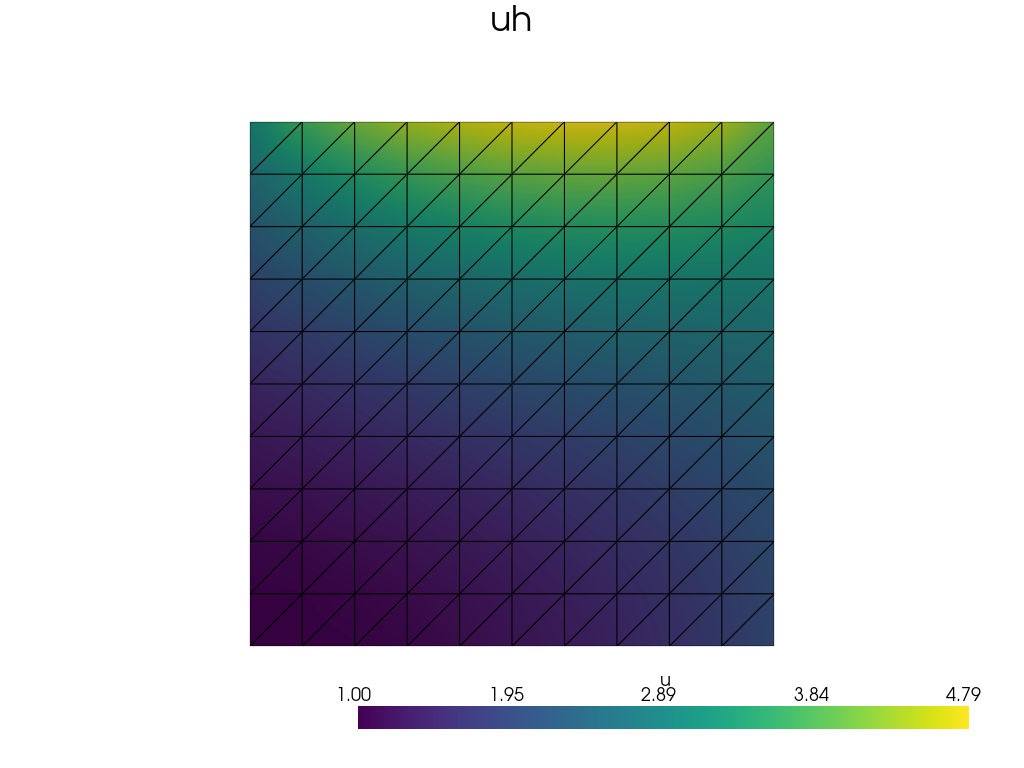

In [22]:
# Solve linear variational problem
a = lhs(F)
L = rhs(F)
problem = LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

# Visualize solution
#pyvista.start_xvfb()
pyvista_cells, cell_types, geometry = vtk_mesh(V)
grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)
grid.point_data["u"] = uh.x.array
grid.set_active_scalars("u")

plotter = pyvista.Plotter()
plotter.add_text("uh", position="upper_edge", font_size=14, color="black")
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("robin_neumann_dirichlet.png")

# Verification

In [23]:
# Compute L2 error and error at nodes
V_ex = functionspace(mesh, ("Lagrange", 2))
u_exact = Function(V_ex)
u_exact.interpolate(u_ex)
error_L2 = np.sqrt(mesh.comm.allreduce(assemble_scalar(form((uh - u_exact)**2 * dx)), op=MPI.SUM))

u_vertex_values = uh.x.array
uex_1 = Function(V)
uex_1.interpolate(u_ex)
u_ex_vertex_values = uex_1.x.array
error_max = np.max(np.abs(u_vertex_values - u_ex_vertex_values))
error_max = mesh.comm.allreduce(error_max, op=MPI.MAX)
print(f"Error_L2 : {error_L2:.2e}")
print(f"Error_max : {error_max:.2e}")

Error_L2 : 4.49e-01
Error_max : 1.46e+00
